# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

#!pip install wget 
#import wget
#wget.download("http://ufldl.stanford.edu/housenumbers/train_32x32.mat")
#wget.download("http://ufldl.stanford.edu/housenumbers/test_32x32.mat")

100% [........................................................................] 64275384 / 64275384

'test_32x32 (1).mat'

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step(ave_loss)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval() # Evaluation mode
    trueAnswerCounter = 0 
    totalAnswerCounter = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
                x = x.to(device)
                y = y.to(device)
                prediction = torch.argmax(model(x) , 1)    
                for i in range(len(prediction)):
                    if prediction[i] == y[i]:
                        trueAnswerCounter += float(1)
                totalAnswerCounter += float(len(prediction))
                
                del prediction

    return float(trueAnswerCounter/totalAnswerCounter)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.442839, Train accuracy: 0.516278, Val accuracy: 0.711965
Average loss: 0.719823, Train accuracy: 0.782104, Val accuracy: 0.780083
Average loss: 0.607837, Train accuracy: 0.818380, Val accuracy: 0.806020
Average loss: 0.560281, Train accuracy: 0.832969, Val accuracy: 0.810593
Average loss: 0.524020, Train accuracy: 0.844367, Val accuracy: 0.839055


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

c:\users\степан\appdata\local\programs\python\python39\lib\site-packages\torchvision\transforms\transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

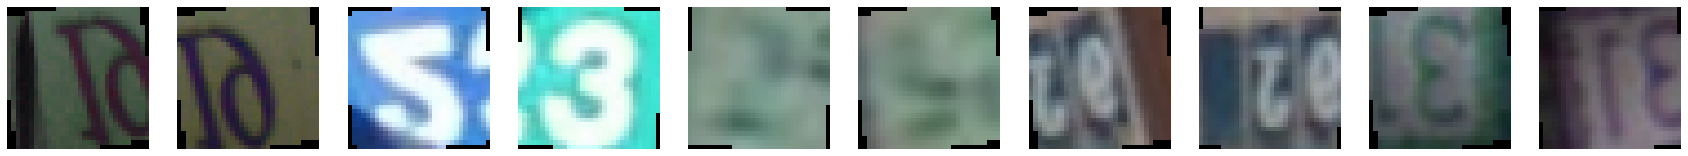

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

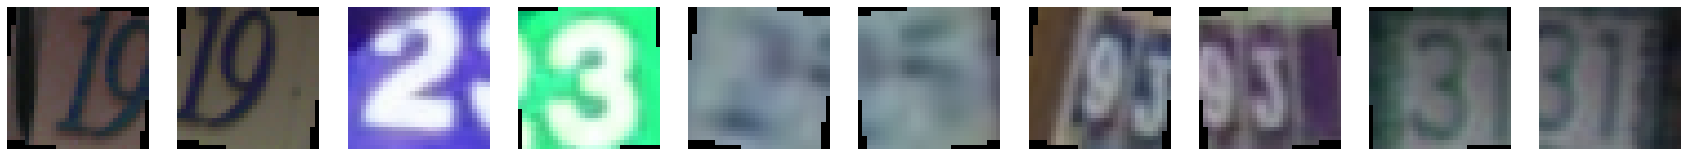

In [11]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)                          
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.924172, Train accuracy: 0.316128, Val accuracy: 0.447137
Average loss: 1.703066, Train accuracy: 0.390148, Val accuracy: 0.503515
Average loss: 1.615564, Train accuracy: 0.425963, Val accuracy: 0.510068
Average loss: 1.560174, Train accuracy: 0.447753, Val accuracy: 0.508088
Average loss: 1.523750, Train accuracy: 0.459236, Val accuracy: 0.514982


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task

lenet_model = nn.Sequential(
nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
nn.MaxPool2d(kernel_size=2),
nn.ReLU(inplace=True),

nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
nn.MaxPool2d(kernel_size=2),
nn.ReLU(inplace=True),

Flattener(),

nn.Linear(16*5*5, 120),
nn.ReLU(inplace=True),

nn.Linear(120, 84),
nn.ReLU(inplace=True),

nn.Linear(84, 10))

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 2.145817, Train accuracy: 0.226564, Val accuracy: 0.408300
Average loss: 1.553668, Train accuracy: 0.451797, Val accuracy: 0.552932
Average loss: 1.279018, Train accuracy: 0.561632, Val accuracy: 0.614839
Average loss: 1.144041, Train accuracy: 0.607839, Val accuracy: 0.626032
Average loss: 1.065721, Train accuracy: 0.635549, Val accuracy: 0.646236
Average loss: 1.026487, Train accuracy: 0.650855, Val accuracy: 0.667122
Average loss: 0.994068, Train accuracy: 0.660939, Val accuracy: 0.654358
Average loss: 0.967729, Train accuracy: 0.669181, Val accuracy: 0.657088
Average loss: 0.942735, Train accuracy: 0.677490, Val accuracy: 0.693332
Average loss: 0.927515, Train accuracy: 0.684896, Val accuracy: 0.676473


# Подбор гиперпараметров

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 


for lrates in learning_rates:
    for rgs in reg:

        print("learning rater: " , lrates, " refularization: ", rgs)
    
        lenet_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(inplace=True),
    
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(inplace=True),
    
        Flattener(),
    
        nn.Linear(16*5*5, 120),
        nn.ReLU(inplace=True),
    
        nn.Linear(120, 84),
        nn.ReLU(inplace=True),
    
        nn.Linear(84, 10))
    
        lenet_model.type(torch.cuda.FloatTensor)
        lenet_model.to(device)
    
        loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
        optimizer = optim.SGD(lenet_model.parameters(), lr=lrates, weight_decay=rgs)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 2, verbose = True)
        loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)
        
        run_record[Hyperparams(lrates, anneal_epochs[0],  rgs)] = RunResult(lenet_model, train_history, val_history , val_history[-1])

learning rater:  1.0  refularization:  0.001
Average loss: 2.243560, Train accuracy: 0.186175, Val accuracy: 0.195345
Average loss: 2.243999, Train accuracy: 0.186483, Val accuracy: 0.195345
Average loss: 2.243618, Train accuracy: 0.186721, Val accuracy: 0.195345
Epoch     4: reducing learning rate of group 0 to 5.0000e-01.
Average loss: 2.243858, Train accuracy: 0.186977, Val accuracy: 0.195345
Average loss: 2.241978, Train accuracy: 0.187677, Val accuracy: 0.195345
learning rater:  1.0  refularization:  0.0001
Average loss: 2.198494, Train accuracy: 0.214824, Val accuracy: 0.195482
Average loss: 2.222151, Train accuracy: 0.198427, Val accuracy: 0.253020
Average loss: 2.200025, Train accuracy: 0.215507, Val accuracy: 0.195550
Epoch     4: reducing learning rate of group 0 to 5.0000e-01.
Average loss: 2.219222, Train accuracy: 0.206566, Val accuracy: 0.195345
Average loss: 2.242036, Train accuracy: 0.187728, Val accuracy: 0.195345
learning rater:  1.0  refularization:  1e-05
Average lo

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.67, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=1, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [12]:
print("starting gym training ")

lrates = 0.002
rgs = 1e-05
epoch_num = 20

best_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(kernel_size=2),

    Flattener(),

    nn.Linear(512, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),

    nn.Linear(1024, 10))

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(best_model.parameters(), lr=lrates, weight_decay=rgs)
#optimizer = optim.Adam(best_model.parameters(), lr=lrates, weight_decay=rgs)
optimizer = optim.Adagrad(best_model.parameters(), lr=lrates, weight_decay=rgs)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 2, verbose = False)
#scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

starting gym training 
Average loss: 2.267137, Train accuracy: 0.174658, Val accuracy: 0.188520
Average loss: 2.243175, Train accuracy: 0.187370, Val accuracy: 0.189816
Average loss: 1.743498, Train accuracy: 0.376088, Val accuracy: 0.752986
Average loss: 0.550480, Train accuracy: 0.828209, Val accuracy: 0.878780
Average loss: 0.370281, Train accuracy: 0.889090, Val accuracy: 0.879872
Average loss: 0.301625, Train accuracy: 0.910658, Val accuracy: 0.903147


KeyboardInterrupt: 

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [13]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9235940381069453


In [15]:
print("cla$$ =)")

cla$$ =)
